# In-hand Cube Rotation Policy Training Notebook

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [17]:
import functools
import json
from datetime import datetime

import jax
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp

from mujoco_playground import manipulation, wrapper
from mujoco_playground.config import manipulation_params

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [18]:
env_name = "LeapAllosaurusRotateZAxis"
env_cfg = manipulation.get_default_config(env_name)
randomizer = manipulation.get_domain_randomizer(env_name)
ppo_params = manipulation_params.brax_ppo_config(env_name)

Env 'LeapAllosaurusRotateZAxis' does not have a domain randomizer in the manipulation registry.


In [19]:
from pprint import pprint

ppo_params.num_timesteps = 100_000_000
pprint(ppo_params)
pprint(env_cfg)

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 500
learning_rate: 0.0003
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 10
num_minibatches: 32
num_resets_per_eval: 1
num_timesteps: 100000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 40

action_repeat: 1
action_scale: 0.6
ctrl_dt: 0.05
early_termination: true
episode_length: 500
history_len: 1
noise_config:
  level: 1.0
  scales:
    joint_pos: 0.05
reward_config:
  scales:
    action_rate: 0.0
    angvel: 1.0
    energy: 0.0
    linvel: 0.0
    pose: 0.0
    termination: -100.0
    torques: 0.0
sim_dt: 0.01



In [20]:
# Setup wandb logging.
USE_WANDB = False
# del wandb
if USE_WANDB:
  wandb.init(project="mjxrl", config=env_cfg)
  wandb.config.update({
      "env_name": env_name,
  })

In [21]:
SUFFIX = "allosaurusnotouch"
FINETUNE_PATH = None
# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
  exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
  FINETUNE_PATH = epath.Path(FINETUNE_PATH)
  latest_ckpts = list(FINETUNE_PATH.glob("*"))
  latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
  latest_ckpts.sort(key=lambda x: int(x.name))
  latest_ckpt = latest_ckpts[-1]
  restore_checkpoint_path = latest_ckpt
  print(f"Restoring from: {restore_checkpoint_path}")
else:
  restore_checkpoint_path = None

Experiment name: LeapAllosaurusRotateZAxis-20250809-125053-allosaurusnotouch


In [22]:
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_dict(), fp, indent=4)

/home/edward/mujoco_playground/checkpoints/LeapAllosaurusRotateZAxis-20250809-125053-allosaurusnotouch


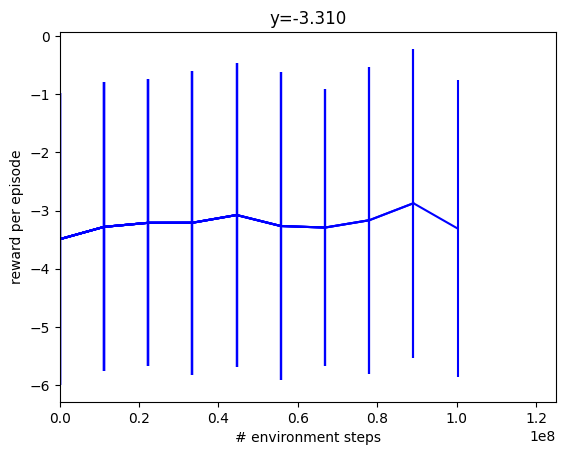

time to jit: 0:02:03.678102
time to train: 0:33:21.373439


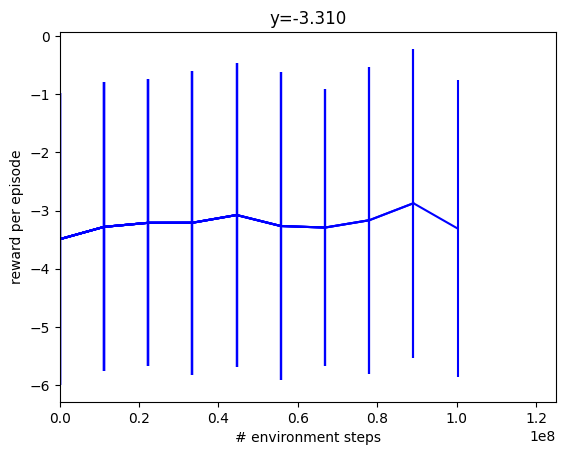

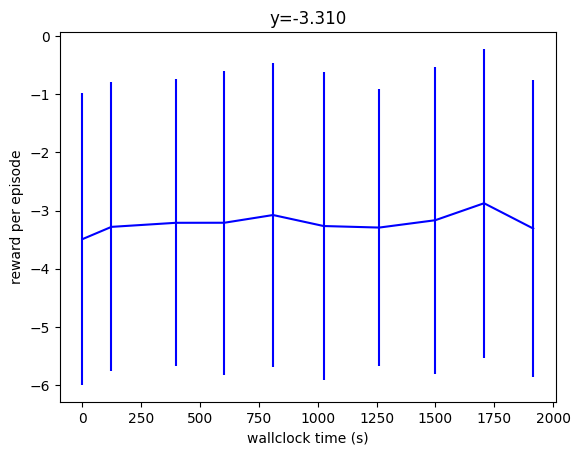

In [23]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  # Log to wandb.
  if USE_WANDB:
    wandb.log(metrics, step=num_steps)

  # Plot.
  clear_output(wait=True)
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params.num_timesteps * 1.25])
  # plt.ylim([0, 75])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)

training_params = dict(ppo_params)
del training_params["network_factory"]
# training_params["num_timesteps"] = 1_000_000

train_fn = functools.partial(
  ppo.train,
  **training_params,
  network_factory=functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  ),
  restore_checkpoint_path=restore_checkpoint_path,
  progress_fn=progress,
  wrap_env_fn=wrapper.wrap_for_brax_training,
  policy_params_fn=policy_params_fn,
  randomization_fn=randomizer,
)

env = manipulation.load(env_name, config=env_cfg)
eval_env = manipulation.load(env_name, config=env_cfg)
make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
if len(times) > 1:
  print(f"time to jit: {times[1] - times[0]}")
  print(f"time to train: {times[-1] - times[1]}")

# Make a final plot of reward and success vs WALLCLOCK time.
plt.figure()
# plt.ylim([0, 75])
plt.xlabel("wallclock time (s)")
plt.ylabel("reward per episode")
plt.title(f"y={y_data[-1]:.3f}")
plt.errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    y_data,
    yerr=y_dataerr,
    color="blue",
)
plt.show()

In [24]:
import pickle
# Save normalizer and policy params to the checkpoint dir.
normalizer_params, policy_params, value_params = params
with open(ckpt_path / "params.pkl", "wb") as f:
  data = {
    "normalizer_params": normalizer_params,
    "policy_params": policy_params,
    "value_params": value_params,
  }
  pickle.dump(data, f)

In [25]:
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

eval_env = manipulation.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [23]:
rng = jax.random.PRNGKey(123)
rollout = [state := jit_reset(rng)]
actions = []
rewards = []
cube_angvel = []
cube_angacc = []
for i in range(env_cfg.episode_length):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  rewards.append({k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")})
  actions.append({
      "policy_output": ctrl,
      "motor_targets": state.info["motor_targets"],
  })
  cube_angvel.append(env.get_object_angvel(state.data, "allosaurus"))
  cube_angacc.append(env.get_object_angacc(state.data, "allosaurus"))
  print(f"step {i}")
  # if state.done:
  #   print("Done detected, stopping rollout.")
  #   break

step 0


/home/edward/mujoco_playground/.venv/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
step 123
s

nan


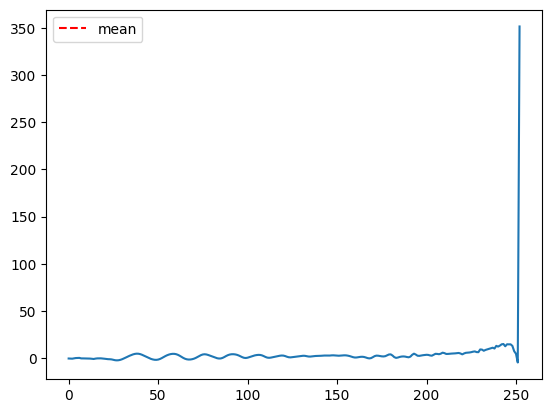

In [26]:
import jax.numpy as jp

z_angvel = [c[3] for c in cube_angvel]
z_angvel = jp.array(z_angvel)

# Smooth.
z_angvel = jp.convolve(z_angvel, jp.ones(10) / 10, mode="valid")
plt.plot(z_angvel)

# Plot mean as horizontal line.
print(jp.mean(z_angvel))
plt.axhline(jp.mean(z_angvel), color="red", linestyle="--", label="mean")
plt.legend()
plt.show()

In [27]:
render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")

traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False

eval_env.mj_model.stat.meansize = 0.02
eval_env.mj_model.stat.extent = 0.25
eval_env.mj_model.vis.global_.azimuth = 140
eval_env.mj_model.vis.global_.elevation = -25
frames = eval_env.render(
    traj, height=480, width=640, scene_option=scene_option
)
media.show_video(frames, fps=fps)
media.write_video(f"{env_name}.mp4", frames, fps=fps)

fps: 20.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:01<00:00, 441.15it/s]


In [ ]:
print(state.info.values())

dict_values([Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32), Array([nan, nan, nan], dtype=float32), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32), Array([1349684964, 2180653274], dtype=uint32)])


: 